In [1]:
from data_preprocess import *
from train_and_test import *
from config_loader import *
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 跑通model_v1

In [ ]:
model_name = 'det'
# 参数
model_config = models_config[model_name]
batch_size, lr, optim_name, epochs, metric, alpha = (
    model_config['batch_size'],
    model_config['lr'],
    model_config['optimizer'],
    model_config['epochs'],
    model_config['metric'],
    model_config.get('alpha', None)
)

In [14]:
set_seed(42)

# 数据
batteries_df = read_and_norm(data_path, rated_capacity, failure_threshold)  
train_df, _, test_df, train_loader, _, test_loader = load_data(batteries_df, test_bat, seq_length, batch_size)

In [15]:
# 模型、优化器
model = get_model(model_config, device)
optimizer = get_optimizer(optim_name, model, lr, alpha)
criterion = nn.MSELoss()

# 训练
model_save_path = 'saved_models/demo_{}.pth'.format(model_name)

best_metric = float('inf')
for epoch in range(epochs):
    train_loss = train_epoch(model_config, model, train_loader, device, optimizer, criterion)
    test_loss = test_epoch(model_config, model, test_loader, device, criterion)

    # 在训练集上预测, 并计算评价指标(SP=0)
    sp = 0.0
    train_bats = train_df['battery'].unique()
    train_re_list, train_rmse_list, train_mae_list = [], [], []
    for bat in train_bats:
        bat_df = train_df[train_df['battery'] == bat]
        train_seq = bat_df['capacity'].to_numpy()
        train_pred_seq = predict(model_config, model, sp, train_seq, seq_length, failure_threshold, device)
        train_re, train_rmse, train_mae = cal_metrics(train_seq, train_pred_seq, sp, seq_length, failure_threshold)
        train_re_list.append(train_re)
        train_rmse_list.append(train_rmse)
        train_mae_list.append(train_mae)
    mean_train_re = np.mean(train_re_list)
    mean_train_rmse = np.mean(train_rmse_list)
    mean_train_mae = np.mean(train_mae_list)

    # 在测试集上预测, 并计算评价指标(SP=0)
    test_seq = test_df['capacity'].to_numpy()
    test_pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
    test_re, test_rmse, test_mae = cal_metrics(test_seq, test_pred_seq, sp, seq_length, failure_threshold)

    print(
        f"Epoch [{epoch+1}/{epochs}], "
        f"Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}, "
        f"Train RE: {mean_train_re:.3f}, Train RMSE: {mean_train_rmse:.4f}, Train MAE: {mean_train_mae:.4f}, "
        f"Test RE: {test_re:.3f}, Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}"
    )    

    # 保存模型
    metric = mean_train_re
    if metric < best_metric:
        best_metric = metric
        torch.save(model.state_dict(), model_save_path)
        print("New best model saved ...")

Epoch [1/200], Train Loss: 0.02736456, Test Loss: 0.00161663, Train RE: 1.000, Train RMSE: 0.1299, Train MAE: 0.1165, Test RE: 1.000, Test RMSE: 0.1311, Test MAE: 0.1182
New best model saved ...
Epoch [2/200], Train Loss: 0.00089209, Test Loss: 0.00100330, Train RE: 0.527, Train RMSE: 0.3738, Train MAE: 0.3075, Test RE: 0.540, Test RMSE: 0.3816, Test MAE: 0.3100
New best model saved ...
Epoch [3/200], Train Loss: 0.00103990, Test Loss: 0.00092341, Train RE: 1.000, Train RMSE: 0.0756, Train MAE: 0.0589, Test RE: 1.000, Test RMSE: 0.0754, Test MAE: 0.0607
Epoch [4/200], Train Loss: 0.00094118, Test Loss: 0.00087344, Train RE: 1.000, Train RMSE: 0.0936, Train MAE: 0.0783, Test RE: 1.000, Test RMSE: 0.0936, Test MAE: 0.0795
Epoch [5/200], Train Loss: 0.00082645, Test Loss: 0.00223626, Train RE: 0.706, Train RMSE: 0.5767, Train MAE: 0.5163, Test RE: 0.707, Test RMSE: 0.5806, Test MAE: 0.5185
Epoch [6/200], Train Loss: 0.00080924, Test Loss: 0.00099190, Train RE: 0.570, Train RMSE: 0.4502, T

Test RE: 0.008, Test RMSE: 0.0321, Test MAE: 0.0272


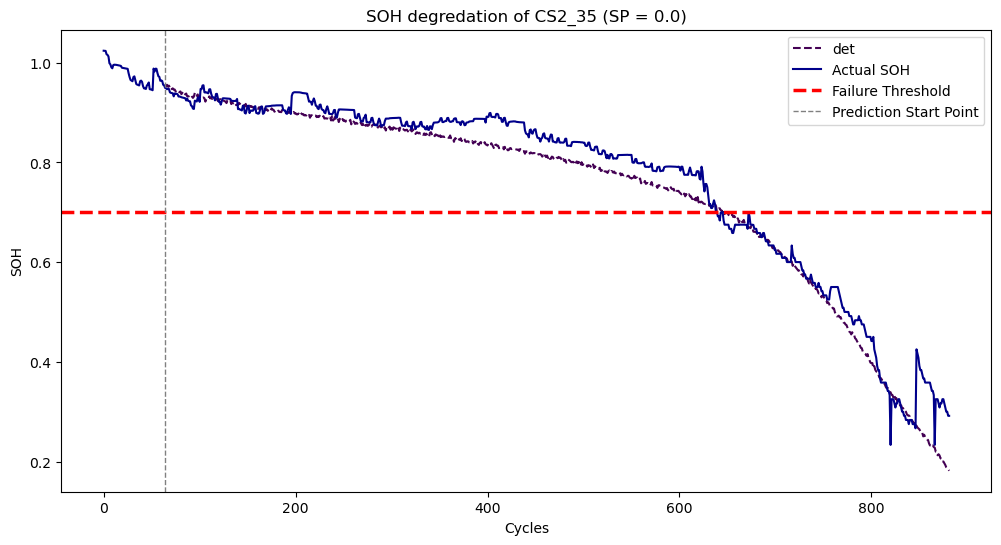

In [16]:
# 测试 (一个模型)
sp = 0.0
pic_save_path = f'pics/{model_name}.png'
test_seq = test_df['capacity'].to_numpy()

# 加载模型
model_config = models_config[model_name]
model = get_model(model_config, device)
model.load_state_dict(torch.load(model_save_path, map_location=device))

# 预测
pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
re, rmse, mae = cal_metrics(test_seq, pred_seq, sp, seq_length, failure_threshold)
print(f"Test RE: {re:.3f}, Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}")

# plot
pred_seqs = {model_name: pred_seq}
plt = plot(test_seq, pred_seqs, sp, failure_threshold, seq_length, test_bat)
plt.savefig(pic_save_path)

## 测试模型能否跑通

In [3]:
from data_preprocess import *
from train_and_test import *
from config_loader import *
import os
import time
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

datasets = ['NASA', 'CALCE']
model_names = ['model_v2_2','model_v4_1', 'model_v5']
for dataset in datasets:
    data_config, models_config, start_points, model_save_dir, seeds, data_path, val_bat, test_bat, bats, seq_length, rated_capacity, failure_threshold, device = load_config(dataset)
    for i in range(1):
        seed = seeds[i]
        set_seed(seed)
        for model_name in model_names:
            # 开始时间
            start_time = time.time()

            # 模型保存路径
            model_save_path = f'saved_models/{dataset}/t-{test_bat[-2:]}_s-{i+1}_{model_name}.pth'

            # 参数
            model_config = models_config[model_name]
            batch_size, lr, optim_name, epochs, metric, alpha = (
                model_config['batch_size'],
                model_config['lr'],
                model_config['optimizer'],
                model_config['epochs'],
                model_config['metric'],
                model_config.get('alpha', None)
            )

            # 数据
            batteries_df = read_and_norm(data_path, rated_capacity, failure_threshold)  
            train_df, _, test_df, train_loader, _, test_loader = load_data(batteries_df, test_bat, seq_length, batch_size)

            # 模型、优化器
            model = get_model(model_config, device, seq_length)
            optimizer = get_optimizer(optim_name, model, lr, alpha)
            criterion = nn.MSELoss()

            # 训练
            best_metric = float('inf')
            for epoch in range(5):
                train_loss = train_epoch(model_config, model, train_loader, device, optimizer, criterion)
                test_loss = test_epoch(model_config, model, test_loader, device, criterion)

                # 在训练集上预测, 并计算评价指标(SP=0)
                sp = 0.0
                train_bats = train_df['battery'].unique()
                train_re_list, train_rmse_list, train_mae_list = [], [], []
                for bat in train_bats:
                    bat_df = train_df[train_df['battery'] == bat]
                    train_seq = bat_df['capacity'].to_numpy()
                    train_pred_seq = predict(model_config, model, sp, train_seq, seq_length, failure_threshold, device)
                    train_re, train_rmse, train_mae = cal_metrics(train_seq, train_pred_seq, sp, seq_length, failure_threshold)
                    train_re_list.append(train_re)
                    train_rmse_list.append(train_rmse)
                    train_mae_list.append(train_mae)
                mean_train_re = np.mean(train_re_list)
                mean_train_rmse = np.mean(train_rmse_list)
                mean_train_mae = np.mean(train_mae_list)

                # 在测试集上预测, 并计算评价指标(SP=0)
                test_seq = test_df['capacity'].to_numpy()
                test_pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
                test_re, test_rmse, test_mae = cal_metrics(test_seq, test_pred_seq, sp, seq_length, failure_threshold)

                print(
                    f"Dataset: {dataset}, Test bat: {test_bat}, Seed: {i+1}, Model: {model_name}, Epoch [{epoch+1}/{epochs}] | "
                    f"Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f} | "
                    f"Train RE: {mean_train_re:.3f}, Test RE: {test_re:.3f}"
                )    

                # 保存模型
                metric = mean_train_re
                if metric < best_metric:
                    best_metric = metric
                    best_model_re, best_model_rmse, best_model_mae = test_re, test_rmse, test_mae
                    print("New best model saved ...")
            
            # 记录实验时间
            end_time = time.time()
            elapsed_time = end_time - start_time 

Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v2_2, Epoch [1/200] | Train Loss: 0.02958058, Test Loss: 0.00528306 | Train RE: 1.000, Test RE: 1.000
New best model saved ...
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v2_2, Epoch [2/200] | Train Loss: 0.01395655, Test Loss: 0.00496699 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v2_2, Epoch [3/200] | Train Loss: 0.00966895, Test Loss: 0.00152849 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v2_2, Epoch [4/200] | Train Loss: 0.00671214, Test Loss: 0.00228386 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v2_2, Epoch [5/200] | Train Loss: 0.00496406, Test Loss: 0.00262892 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v4_1, Epoch [1/200] | Train Loss: 0.62920616, Test Loss: 0.04164090 | Train RE: 1.000, Test RE: 1.000
New best model saved ...
Dataset: NASA,

# 一次训练多个模型

In [5]:
import pandas as pd

file_path = 'result/result_temp.csv'
df = pd.read_csv(file_path)
display(df)
df = df.drop(index=range(440, 455))
display(df)
df.to_csv(file_path, index=False)

,dataset,test_bat,seed,model,re,rmse,mae,time
0,NASA,B0005,1,lstm,0.168,0.050936,0.048400,NaN
1,NASA,B0005,1,gru,0.192,0.060057,0.056878,NaN
2,NASA,B0005,1,det,0.200,0.051990,0.049927,NaN
3,NASA,B0005,1,model_v1,0.192,0.053052,0.050739,NaN
4,NASA,B0005,2,lstm,0.176,0.052814,0.050465,NaN
...,...,...,...,...,...,...,...,...
450,NASA,B0005,4,model_v2_1,0.184,0.050914,0.048654,324.557370
451,NASA,B0005,4,model_v3,0.240,0.066413,0.062001,337.792409
452,NASA,B0005,5,model_v1,0.160,0.026175,0.023256,301.111405
453,NASA,B0005,5,model_v2_1,0.216,0.059476,0.058047,321.021652


,dataset,test_bat,seed,model,re,rmse,mae,time
0,NASA,B0005,1,lstm,0.168000,0.050936,0.048400,NaN
1,NASA,B0005,1,gru,0.192000,0.060057,0.056878,NaN
2,NASA,B0005,1,det,0.200000,0.051990,0.049927,NaN
3,NASA,B0005,1,model_v1,0.192000,0.053052,0.050739,NaN
4,NASA,B0005,2,lstm,0.176000,0.052814,0.050465,NaN
...,...,...,...,...,...,...,...,...
435,CALCE,CS2_38,4,model_v4_1,0.126005,0.088533,0.042103,1428.429712
436,CALCE,CS2_38,4,model_v5,0.154155,0.073624,0.064960,683.973796
437,CALCE,CS2_38,5,model_v2_2,0.407507,0.296788,0.206103,632.590126
438,CALCE,CS2_38,5,model_v4_1,0.171582,0.105869,0.059127,1437.092327


In [1]:
from data_preprocess import *
from train_and_test import *
from config_loader import *
import os
import time
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

datasets = ['NASA', 'CALCE']
model_names = ['model_v1', 'model_v2', 'model_v2_1', 'model_v3', 'model_v4']
for dataset in datasets:
    data_config, models_config, start_points, model_save_dir, seeds, data_path, val_bat, _, bats, seq_length, rated_capacity, failure_threshold, device = load_config(dataset)
    for test_bat in bats:
        for i in range(len(seeds)):
            seed = seeds[i]
            set_seed(seed)
            for model_name in model_names:
                # 开始时间
                start_time = time.time()

                # 模型保存路径
                model_save_path = f'saved_models/{dataset}/t-{test_bat[-2:]}_s-{i+1}_{model_name}.pth'

                # 参数
                model_config = models_config[model_name]
                batch_size, lr, optim_name, epochs, metric, alpha = (
                    model_config['batch_size'],
                    model_config['lr'],
                    model_config['optimizer'],
                    model_config['epochs'],
                    model_config['metric'],
                    model_config.get('alpha', None)
                )

                # 数据
                batteries_df = read_and_norm(data_path, rated_capacity, failure_threshold)  
                train_df, _, test_df, train_loader, _, test_loader = load_data(batteries_df, test_bat, seq_length, batch_size)

                # 模型、优化器
                model = get_model(model_config, device, seq_length)
                optimizer = get_optimizer(optim_name, model, lr, alpha)
                criterion = nn.MSELoss()

                # 训练
                best_metric = float('inf')
                for epoch in range(epochs):
                    train_loss = train_epoch(model_config, model, train_loader, device, optimizer, criterion)
                    test_loss = test_epoch(model_config, model, test_loader, device, criterion)

                    # 在训练集上预测, 并计算评价指标(SP=0)
                    sp = 0.0
                    train_bats = train_df['battery'].unique()
                    train_re_list, train_rmse_list, train_mae_list = [], [], []
                    for bat in train_bats:
                        bat_df = train_df[train_df['battery'] == bat]
                        train_seq = bat_df['capacity'].to_numpy()
                        train_pred_seq = predict(model_config, model, sp, train_seq, seq_length, failure_threshold, device)
                        train_re, train_rmse, train_mae = cal_metrics(train_seq, train_pred_seq, sp, seq_length, failure_threshold)
                        train_re_list.append(train_re)
                        train_rmse_list.append(train_rmse)
                        train_mae_list.append(train_mae)
                    mean_train_re = np.mean(train_re_list)
                    mean_train_rmse = np.mean(train_rmse_list)
                    mean_train_mae = np.mean(train_mae_list)

                    # 在测试集上预测, 并计算评价指标(SP=0)
                    test_seq = test_df['capacity'].to_numpy()
                    test_pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
                    test_re, test_rmse, test_mae = cal_metrics(test_seq, test_pred_seq, sp, seq_length, failure_threshold)

                    print(
                        f"Dataset: {dataset}, Test bat: {test_bat}, Seed: {i+1}, Model: {model_name}, Epoch [{epoch+1}/{epochs}] | "
                        f"Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f} | "
                        f"Train RE: {mean_train_re:.3f}, Test RE: {test_re:.3f}"
                    )    

                    # 保存模型
                    metric = mean_train_re
                    if metric < best_metric:
                        best_metric = metric
                        best_model_re, best_model_rmse, best_model_mae = test_re, test_rmse, test_mae
                        torch.save(model.state_dict(), model_save_path)
                        print("New best model saved ...")
                
                # 记录实验时间
                end_time = time.time()
                elapsed_time = end_time - start_time 

                # 保存单个种子、单个模型的结果
                result = {
                    'dataset': dataset,
                    'test_bat': test_bat,
                    'seed': i + 1,
                    'model': model_name,
                    're': best_model_re,
                    'rmse': best_model_rmse,
                    'mae': best_model_mae,
                    'time': elapsed_time
                }

                pd.DataFrame([result]).to_csv('result/result_temp.csv', mode='a', index=False, header=False)

Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v1, Epoch [1/100] | Train Loss: 0.10838964, Test Loss: 0.01719464 | Train RE: 0.856, Test RE: 0.864
New best model saved ...
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v1, Epoch [2/100] | Train Loss: 0.03194569, Test Loss: 0.01568020 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v1, Epoch [3/100] | Train Loss: 0.02215672, Test Loss: 0.00708886 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v1, Epoch [4/100] | Train Loss: 0.01552187, Test Loss: 0.00711386 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v1, Epoch [5/100] | Train Loss: 0.01371746, Test Loss: 0.00723121 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: model_v1, Epoch [6/100] | Train Loss: 0.01374667, Test Loss: 0.00625963 | Train RE: 1.000, Test RE: 1.000
Dataset: NASA, Test bat: B0005, Seed: 1, Model: mod

## 输出结果（表格、曲线）

In [19]:
result_df = pd.read_csv('result/result_temp.csv')
result_df = result_df[result_df['test_bat'].isin(['B0005', 'CS2_35'])]
# result_df = result_df[result_df['model'].isin(['model_v1', 'model_v2', 'model_v2_1', 'model_v3', 'model_v4'])]
metric_df = result_df.groupby(['dataset', 'model']).agg({
    're': ['mean', 'std'],
    'rmse': ['mean', 'std'],
    'mae': ['mean', 'std']
})
metric_df = metric_df.reset_index()
metric_df.columns = ['dataset', 'model', 're_mean', 're_std', 'rmse_mean', 'rmse_std', 'mae_mean', 'mae_std']
metric_df

,dataset,model,re_mean,re_std,rmse_mean,rmse_std,mae_mean,mae_std
0,CALCE,model_v1,0.073011,0.044501,0.028117,0.021545,0.022676,0.018244
1,CALCE,model_v2,0.109828,0.030978,0.026446,0.008260,0.022570,0.007763
2,CALCE,model_v2_1,0.089860,0.051110,0.027115,0.006752,0.022911,0.006775
3,CALCE,model_v2_2,0.080187,0.050414,0.026348,0.010457,0.022201,0.009797
4,CALCE,model_v3,0.067707,0.037743,0.026683,0.016545,0.022036,0.013769
5,CALCE,model_v4,0.284243,0.410497,0.065084,0.074088,0.045683,0.042774
6,CALCE,model_v4_1,0.078939,0.024384,0.031566,0.018721,0.025792,0.016193
7,CALCE,model_v5,0.091732,0.037220,0.022383,0.009602,0.018103,0.008999
8,NASA,model_v1,0.208000,0.044181,0.051863,0.019059,0.048741,0.018026
9,NASA,model_v2,0.222400,0.017344,0.059066,0.010996,0.056342,0.009734


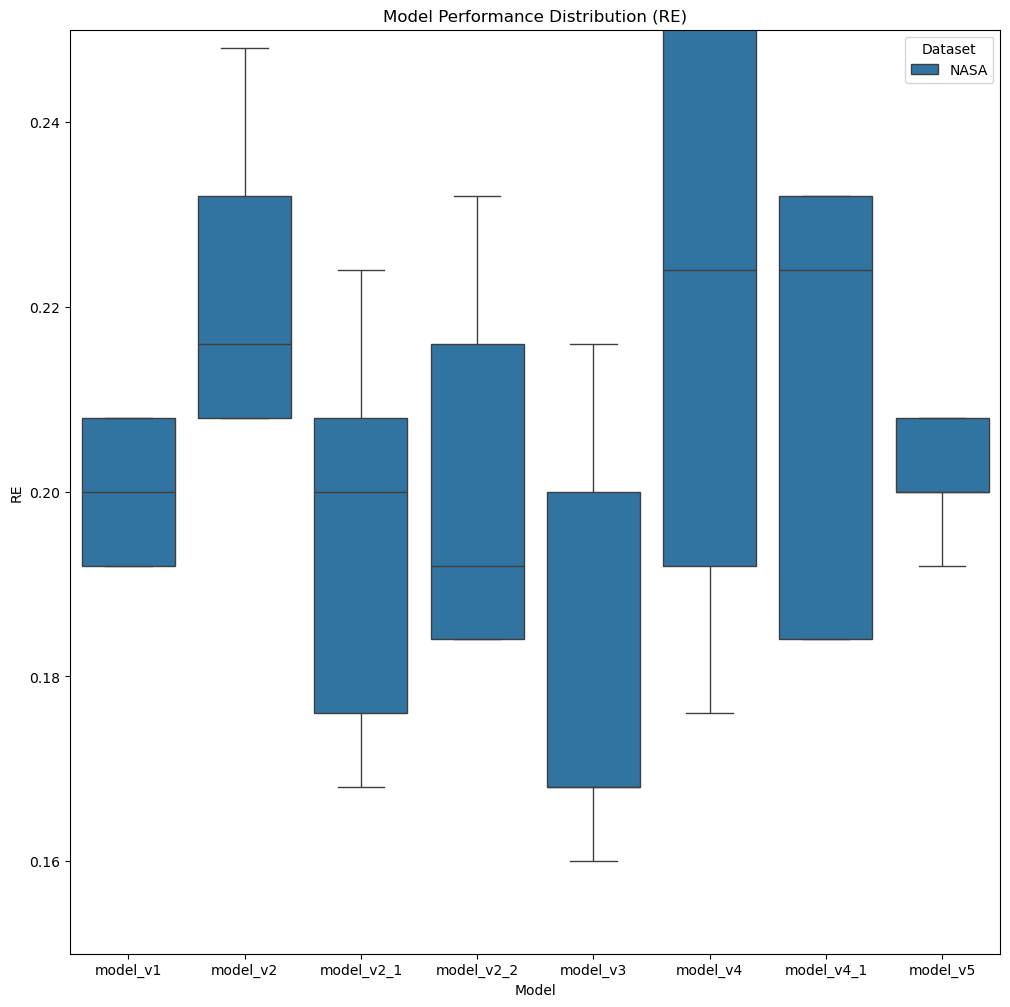

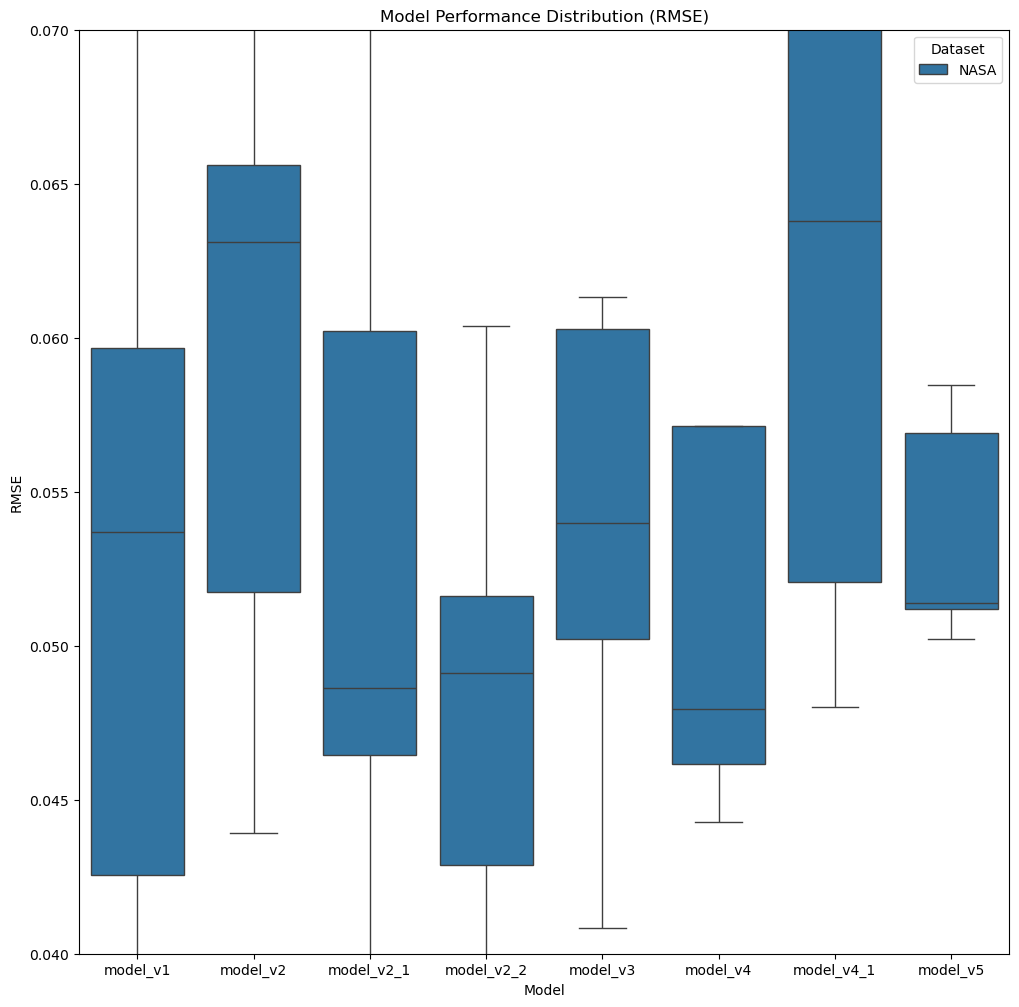

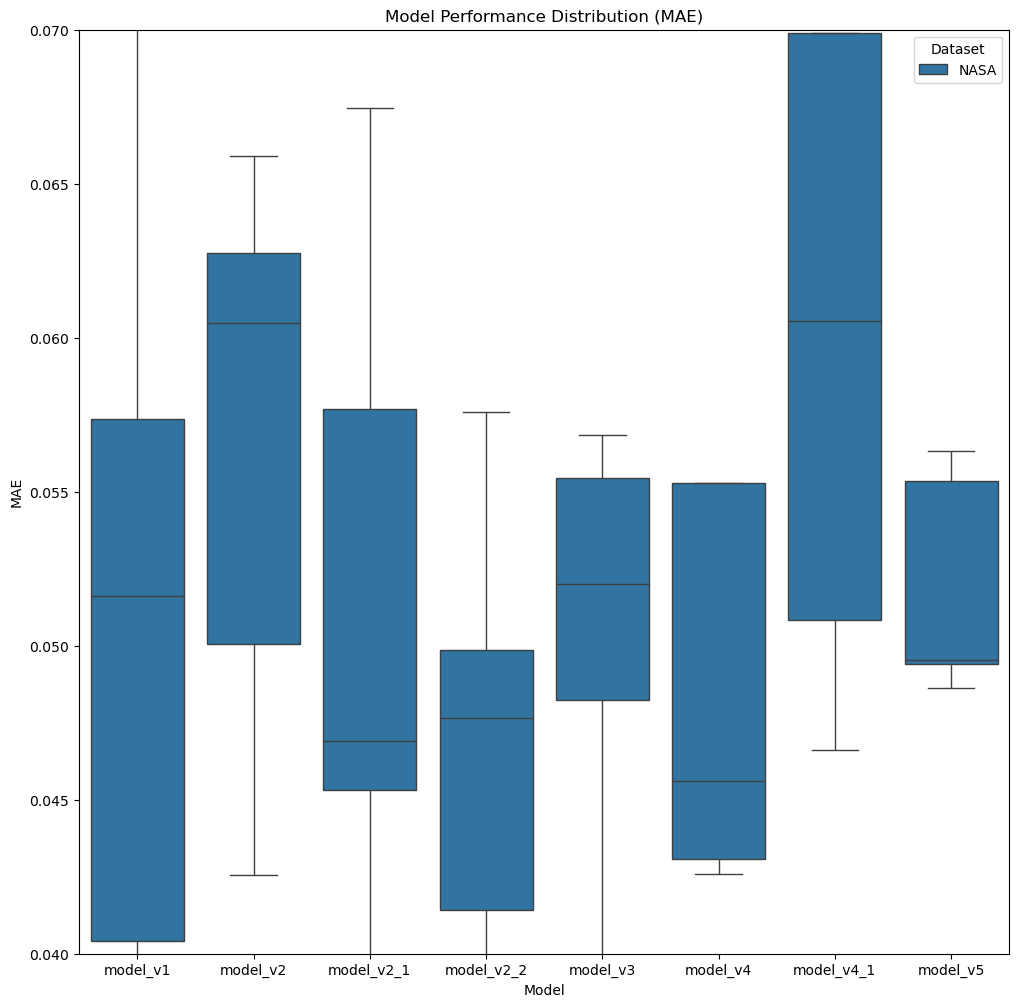

In [24]:
import seaborn as sns

# result_df = pd.read_csv('result/result_temp.csv')
result_df = result_df.sort_values(by='model')
# result_df = result_df[result_df['model'].isin(['model_v1', 'model_v2', 'model_v2_1', 'model_v3', 'model_v4'])]
# 使用 seaborn 逐一绘制
datasets = ['NASA']
metrics = ['re', 'rmse', 'mae']
labels = ['RE', 'RMSE', 'MAE']
for dataset in datasets:
    df = result_df[result_df['dataset'] == dataset]
    for metric, label in zip(metrics, labels):
        plt.figure(figsize=(12, 12))
        sns.boxplot(data=df, x="model", y=metric, hue="dataset", fliersize=0)
        if label == 'RE':
            plt.ylim(0.15, 0.25)
        elif label == 'RMSE':
            plt.ylim(0.04, 0.07)
        else: 
            plt.ylim(0.04, 0.07)
        plt.title(f"Model Performance Distribution ({label})")
        plt.ylabel(label)
        plt.xlabel("Model")
        plt.legend(title="Dataset")
        plt.show()

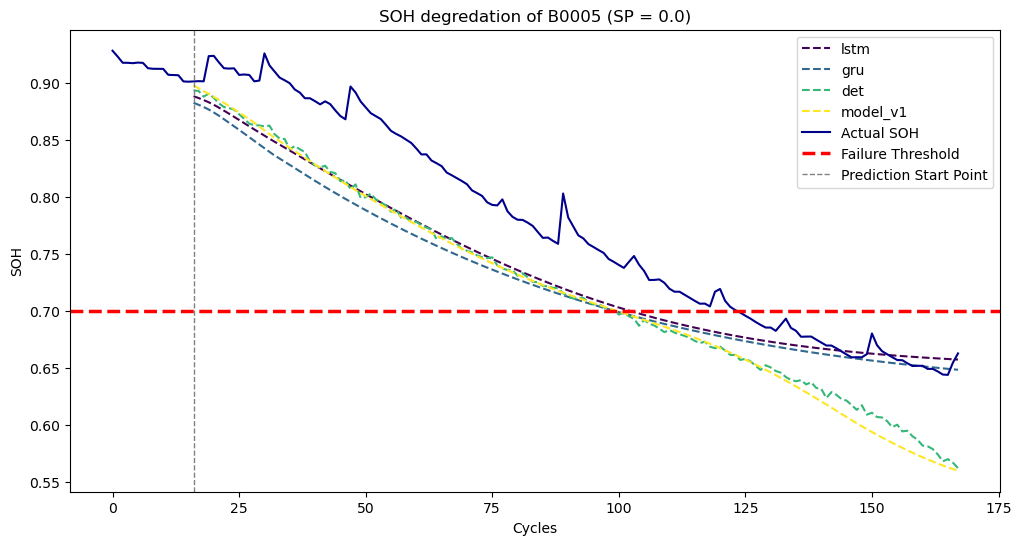

,model,re,rmse,mae
0,lstm,0.168,0.0509,0.0484
1,gru,0.192,0.0601,0.0569
2,det,0.208,0.0526,0.0506
3,model_v1,0.192,0.0531,0.0507


In [6]:
sp = 0.0
pic_save_path = f'pics/{DATASET}/all_models.png'
test_seq = test_df['capacity'].to_numpy()
result = []
pred_seqs = {}

model_names = ['lstm', 'gru', 'det', 'model_v1']
for model_name in model_names:
    model_save_path = f'saved_models/{DATASET}/{model_name}.pth'

    # 加载模型
    model_config = models_config[model_name]
    model = get_model(model_config, device, seq_length)
    model.load_state_dict(torch.load(model_save_path, map_location=device))

    # 预测
    pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
    re, rmse, mae = cal_metrics(test_seq, pred_seq, sp, seq_length, failure_threshold)

    result.append({
        'model': model_name,
        're': round(re, 3),
        'rmse': round(rmse, 4),
        'mae': round(mae, 4)
    })
    pred_seqs[model_name] = pred_seq

plt = plot(test_seq, pred_seqs, sp, failure_threshold, seq_length, test_bat)
plt.savefig(pic_save_path)
plt.show()
result_df = pd.DataFrame(result)
result_df

## 模型性能对比表格：数据集、模型、re、rmse、mae

In [6]:
result_df = pd.read_csv('result/result_v1.csv')
result_df.to_csv('result/result_temp.csv', index=False)

In [11]:
result_df = pd.read_csv("result/result_v1.csv")
result_agg = result_df.groupby(["test_bat", "model"]).agg({
    "re": "mean",
    "rmse": "mean",
    "mae": "mean"
})

# 设置小数位格式化
result_agg["re"] = result_agg["re"].round(3)
result_agg["rmse"] = result_agg["rmse"].round(4)
result_agg["mae"] = result_agg["mae"].round(4)

result_agg

re    rmse     mae
test_bat model                          
B0005    det       0.181  0.0497  0.0474
         gru       0.194  0.0572  0.0548
         lstm      0.179  0.0478  0.0460
         model_v1  0.198  0.0498  0.0470
         model_v2  0.154  0.0513  0.0481
B0006    det       0.066  0.0346  0.0285
         gru       0.059  0.0273  0.0209
         lstm      0.103  0.0307  0.0258
         model_v1  0.083  0.0378  0.0311
         model_v2  0.116  0.0376  0.0304
B0007    det       0.336  0.0948  0.0786
         gru       0.356  0.0730  0.0708
         lstm      0.343  0.0619  0.0603
         model_v1  0.370  0.0767  0.0717
         model_v2  0.327  0.1613  0.1032
B0018    det       0.247  0.0237  0.0190
         gru       0.027  0.0246  0.0170
         lstm      0.025  0.0168  0.0123
         model_v1  0.019  0.0180  0.0137
         model_v2  0.058  0.0218  0.0166
CS2_35   det       0.056  0.0280  0.0234
         gru       0.021  0.0352  0.0309
         lstm      0.007  0.0272  0.0230
         model_v1  0.012  0.0317  0.0258
         model_v2  0.027  0.0694  0.0616
CS2_36   det       0.283  0.0329  0.0288
         gru       0.273  0.0516  0.0485
         lstm      0.248  0.0349  0.0318
         model_v1  0.261  0.0364  0.0306
         model_v2  0.286  0.0749  0.0708
CS2_37   det       0.080  0.0345  0.0266
         gru       0.104  0.0496  0.0422
         lstm      0.106  0.0497  0.0343
         model_v1  0.087  0.0463  0.0336
         model_v2  0.080  0.0696  0.0628
CS2_38   det       0.092  0.0431  0.0308
         gru       0.134  0.0700  0.0552
         lstm      0.134  0.0702  0.0458
         model_v1  0.104  0.0648  0.0541
         model_v2  0.109  0.0746  0.0684